# Train

In [1]:
from custom_transformers import (
    ModifiedBertForSequenceClassification,
    SQLDataset,
    BCEFocalLossWithLogits,
    Trainer,
    AutoTokenizer,
    get_scheduler,
)
from torch.utils.data import (
    DataLoader,
    Subset,
)
from dotenv import load_dotenv
import os
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
load_dotenv()

model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=258,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained('/home/Models/TookaBERT-Base/')

connection_params = {
    'dbname': os.getenv('DBNAME'),
    'user': os.getenv('USERNAME'),
    'password': os.getenv('PASS'),
    'host': os.getenv('HOST', 'localhost'),
    'port': os.getenv('PORT', '5432')
}
dataset = SQLDataset(
    tokenizer,
    connection_params=connection_params,
    num_classes=258
)

Some weights of ModifiedBertForSequenceClassification were not initialized from the model checkpoint at /home/Models/TookaBERT-Base/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


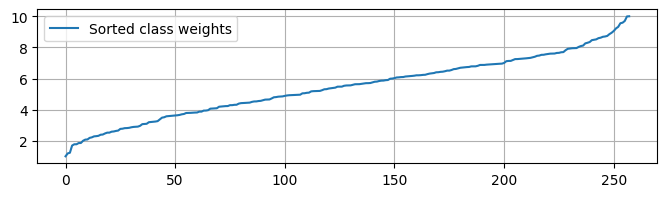

In [3]:
plt.figure(figsize=(8,2))
plt.plot(sorted(dataset.scaled_class_weights), label= 'Sorted class weights')
plt.legend()
plt.grid()
plt.show()

In [4]:
train_indices, test_indices = train_test_split(
    list(dataset.id_map.keys()),
    test_size=0.1,
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, 32, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)
test_loader = DataLoader(test_dataset, 32, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)


# optimizer = AdamW(model.parameters(), lr=5e-5)
#--------------------------------------------------------------------------------------------------------------#
# Define the parameters for the frozen and unfrozen layers
frozen_params = []
unfrozen_params = []

for name, param in model.named_parameters():
    if name in ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']:
        # These layers will have their own learning rate
        unfrozen_params.append(param)
    else:
        # Freezing other layers (don't update their gradients)
        frozen_params.append(param)
optimizer = torch.optim.AdamW(
    [
        {'params': frozen_params, 'lr': 5e-6},   # Frozen layers have a smaller learning rate
        {'params': unfrozen_params, 'lr': 5e-5},  # Unfrozen layers have a larger learning rate
    ],
)
#--------------------------------------------------------------------------------------------------------------#

loss_fn = BCEFocalLossWithLogits(gamma=2, alpha=0.957, class_weights=dataset.scaled_class_weights.to(model.device), reduction="mean")

num_epochs = 20
num_training_steps = len(train_loader) * num_epochs 
warmup_steps = int(0.1 * num_training_steps)

scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

trainer = Trainer(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    test_loader
)

In [7]:
trainer.fit(num_epochs)

Epoch   1/20


Training Loss: 0.1095
Validation Loss: 0.0658

Epoch   2/20


Training Loss: 0.0626
Validation Loss: 0.0599

Epoch   3/20


Training Loss: 0.0555
Validation Loss: 0.0522

Epoch   4/20


Training Loss: 0.0510
Validation Loss: 0.0499

Epoch   5/20


Training Loss: 0.0481
Validation Loss: 0.0484

Epoch   6/20


Training Loss: 0.0458
Validation Loss: 0.0478

Epoch   7/20


Training Loss: 0.0439
Validation Loss: 0.0470

Epoch   8/20


Training Loss: 0.0422
Validation Loss: 0.0465

Epoch   9/20


Training Loss: 0.0408
Validation Loss: 0.0462

Epoch  10/20


Training Loss: 0.0396
Validation Loss: 0.0463

Epoch  11/20


Training Loss: 0.0385
Validation Loss: 0.0464

Epoch  12/20


Training Loss: 0.0375
Validation Loss: 0.0455

Epoch  13/20


Training Loss: 0.0367
Validation Loss: 0.0455

Epoch  14/20


Training Loss: 0.0360
Validation Loss: 0.0453

Epoch  15/20


Training Loss: 0.0354
Validation Loss: 0.0453

Epoch  16/20


Training Loss: 0.0350
Validation Loss: 0.0451

Epoch  17/20


Training Loss: 0.0347
Validation Loss: 0.0451

Epoch  18/20


Training Loss: 0.0344
Validation Loss: 0.0451

Epoch  19/20


Training Loss: 0.0343
Validation Loss: 0.0452

Epoch  20/20


Training Loss: 0.0342
Validation Loss: 0.0452



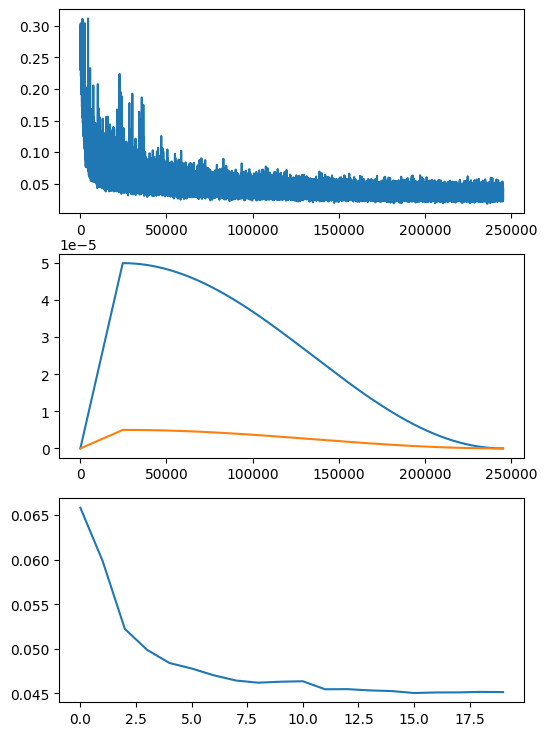

In [8]:
plt.figure(figsize=(6, 9))
plt.subplot(3, 1, 1)
plt.plot([loss for losses in trainer.losses for loss in losses])
plt.subplot(3, 1, 2)
plt.plot([lr[1] for lr in trainer.learning_rates])
plt.plot([lr[0] for lr in trainer.learning_rates])
plt.subplot(3, 1, 3)
plt.plot(trainer.validation_loss)
plt.show()

In [9]:
dataset.tokenizer.save_pretrained('./saved_models/myBERT-Base-436k/')
trainer.model.save_pretrained('./saved_models/myBERT-Base-436k/', safe_serialization=True)
trainer.model.save_pretrained('./saved_models/myBERT-Base-436k/', safe_serialization=False)

# Check

In [42]:
from custom_transformers import (
    ModifiedBertForSequenceClassification,
    AutoTokenizer
)
import torch
from pprint import pprint

In [ ]:
model = ModifiedBertForSequenceClassification.from_pretrained(
    './saved_models/myBERT-Base-436k/',
    num_labels=258,
    # device_map='auto',
).eval()

tokenizer = AutoTokenizer.from_pretrained('./saved_models/myBERT-Base-436k/')

In [8]:
text1 = "ارائه خدمات اموزش زبان انگلیسی و انجام کلیه عملیات مرتبط طبق مجوز فعالیت اقتصادی شماره 264/92 مورخ 10/4/92 سازمان منطقه ازاد قشم."

text2 = "+( خرید و فروش، واردات و صادرات در زمینه موضوع شرکت فناوری اطلاعات، اخذ و اعطای نمایندگی شرکتهای معتبر داخلی و خارجی در زمینه IT مشارکت و سرمایه گذاری و انعقاد قرارداد با کلیه اشخاص حقیقی و حقوقی در زمینه IT و موضوع شرکا، شرکت در کلیه نمایشگاههای داخلی و خارجی در زمینه فناوری اطلاعات، گشایش اعتبارات اسنادی و ترخیص کالاهای مجاز در زمینه فناوری و اطلاعات از گمرکات کشور)"

text3 = 'ارایه کلیه خدمات مهندسی کشاورزی شامل مشاوره اجرا نظارت بر اجرای انواع طرحهای ابیاری قطره ای بارانی تحت فشار و برقی کردن چاه های کشاورزی جهت بهبود عملیات زراعی در مزارع کشاورزی و باغات و تسطیح و اماده سازی و ابخیزداری و زهکشی کلیه زمینهای کشاورزی باغداری ایجاد فضای سبز گلخانه های فضای ازاد تهیه تولید تکثیر و پرورش گلهای اپارتمانی و انواع نهال تهیه تولید خرید فروش بسته بندی واردات صادرات انواع کودهای شیمیایی انواع بذر و نشا و کمپوست و سموم نباتی و ماشین الات کشاورزی و دامپروری ارایه خدمات مشاوره در زمینه بهبود عملیات زراعی و باغداری شناسایی و ردیابی افات زراعی و از بین بردن این افات بصورت علمی شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه امور بازرگانی شامل واردات صادرات ترخیص حق العمل کاری کلیه کالاهای مجاز از کلیه گمرکات و بنادر کشور و شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه عملیات اجرایی انواع طرحهای مخابراتی تاسیساتی ساختمانی راهسازی و گاز رسانی ابرسانی شهری و روستایی صنعتی شامل حفاری کابل کشی لوله گذاری کانال سازی خاکبرداری و جدول کشی انجام کلیه امور پروژه های ساختمانی مسکونی اسفالت کاری اسکلت سازی و محوطه سازی و تخریب و خاکبرداری خاکریزی و پی کنی دیوار چینی کلیه امور نقشه کشی (Gps – GPRS) کلیه امور اسنادی (خدمات اسنادی قبض انبار منطقه ویژه اصلاحیه مانیفست صورتحساب مجوز خروج کالا (بیجک) تسویه و صورت مجالس شناور صورت وضعیت خروج شناور)',

In [66]:
# %%timeit
tokens = tokenizer(
    text3,
    truncation=True,
    padding=True,
    return_tensors='pt'
)

with torch.no_grad():
    output = model(**tokens.to(model.device))

theshold = 0.7
probs = torch.sigmoid(output.logits[0])
labels = torch.argwhere(probs > theshold).view(-1).tolist()

sorted_items = sorted(
    {label: prob.item() for label, prob in zip(labels, probs[labels])}.items(),
    key=lambda x: x[1],
    reverse=True
)
pprint(
    sorted_items
)

[(5, 0.9979227185249329),
 (3, 0.985106348991394),
 (4, 0.9826263189315796),
 (186, 0.9676409363746643),
 (194, 0.9580788612365723),
 (1, 0.9557887315750122),
 (0, 0.9162304997444153),
 (10, 0.88196861743927),
 (76, 0.8617027401924133),
 (77, 0.8329512476921082),
 (221, 0.825063169002533),
 (182, 0.809560239315033),
 (242, 0.8055773973464966),
 (244, 0.8050119280815125),
 (183, 0.7866716384887695),
 (184, 0.7700743079185486),
 (255, 0.7295392155647278),
 (198, 0.7228794097900391),
 (132, 0.7141934633255005),
 (252, 0.7125767469406128),
 (112, 0.7089396119117737),
 (212, 0.7051270604133606)]


In [67]:
print([x[0] for x in sorted_items])

[5, 3, 4, 186, 194, 1, 0, 10, 76, 77, 221, 182, 242, 244, 183, 184, 255, 198, 132, 252, 112, 212]


In [70]:
pprint(text3, width=120)

('ارایه کلیه خدمات مهندسی کشاورزی شامل مشاوره اجرا نظارت بر اجرای انواع طرحهای ابیاری قطره ای بارانی تحت فشار و برقی '
 'کردن چاه های کشاورزی جهت بهبود عملیات زراعی در مزارع کشاورزی و باغات و تسطیح و اماده سازی و ابخیزداری و زهکشی کلیه '
 'زمینهای کشاورزی باغداری ایجاد فضای سبز گلخانه های فضای ازاد تهیه تولید تکثیر و پرورش گلهای اپارتمانی و انواع نهال '
 'تهیه تولید خرید فروش بسته بندی واردات صادرات انواع کودهای شیمیایی انواع بذر و نشا و کمپوست و سموم نباتی و ماشین الات '
 'کشاورزی و دامپروری ارایه خدمات مشاوره در زمینه بهبود عملیات زراعی و باغداری شناسایی و ردیابی افات زراعی و از بین '
 'بردن این افات بصورت علمی شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام '
 'کلیه امور بازرگانی شامل واردات صادرات ترخیص حق العمل کاری کلیه کالاهای مجاز از کلیه گمرکات و بنادر کشور و شرکت در '
 'مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه عملیات اجرایی انواع طرحهای '
 'مخابراتی تاسیساتی ساختمانی راهسازی و گاز رسانی ابرسان